# Variational Autoencdoder

A simple variational autoencoder that compresses 768-pixel MNIST images down to a 15-pixel latent vector representation.

In [3]:
%load_ext watermark
%watermark -a 'Nilesh Thakkar' -v -p torch

Author: Nilesh Thakkar

Python implementation: CPython
Python version       : 3.9.19
IPython version      : 8.15.0

torch: 2.2.2



## Imports

In [5]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [6]:
## Settings

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

## hyperparameters
random_seed = 0
learning_rate = 0.001
num_epochs = 50
batch_size = 128

# Architecture
num_features = 784
num_hidden_1 = 500
num_latent = 15

Device: cpu


In [7]:
## MNIST dataset
train_dataset = datasets.MNIST(root='../data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='../data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


## Model

In [14]:
class VariationalAutoencoder(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_latent):
        super(VariationalAutoencoder, self).__init__()

        # Encoder
        self.hidden_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.z_mean = torch.nn.Linear(num_hidden_1, num_latent)
        self.z_log_var = torch.nn.Linear(num_hidden_1, num_latent)

        #Decoder
        self.linear_3 = torch.nn.Linear(num_latent, num_hidden_1)
        self.linear_4 = torch.nn.Linear(num_hidden_1, num_features)

    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(device)
        z = z_mu + eps + torch.exp(z_log_var/2.)

        return z

    def encoder(self, features):
        x = self.hidden_1(features)
        x = F.leaky_relu(x, negative_slope=0.0001)
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return z_mean, z_log_var, encoded

    def decoder(self, encoded):
        x = self.linear_3(encoded)
        x = F.leaky_relu(x, negative_slope=0.0001)
        x = self.linear_4(x)
        decoded = torch.sigmoid(x)
        return decoded

    def forward(self, features):

        z_mean, z_log_var, encoded = self.encoder(features)
        decoded = self.decoder(encoded)

        return z_mean, z_log_var, encoded, decoded

torch.manual_seed(random_seed)
model = VariationalAutoencoder(num_features,
                               num_hidden_1,
                               num_latent)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training

In [15]:
start_time = time.time()
for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        # don't need labels, only features
        features = features.view(-1, 28*28).to(device)

        # Forward and Backprop steps
        z_mean, z_log_var, encoded, decoded = model(features)
        # cost = reconstruction loss + Kullback-Leibler divergence
        kl_divergence = (0.5 * (z_mean**2 + 
                                torch.exp(z_log_var) - z_log_var - 1)).sum()
        pixelwise_bce = F.binary_cross_entropy(decoded, features, reduction='sum')
        cost = kl_divergence + pixelwise_bce
        
        optimizer.zero_grad()
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
            
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/050 | Batch 000/469 | Cost: 71689.5859
Epoch: 001/050 | Batch 050/469 | Cost: 25469.7734
Epoch: 001/050 | Batch 100/469 | Cost: 21969.3203
Epoch: 001/050 | Batch 150/469 | Cost: 20412.6230
Epoch: 001/050 | Batch 200/469 | Cost: 19243.9531
Epoch: 001/050 | Batch 250/469 | Cost: 19036.2891
Epoch: 001/050 | Batch 300/469 | Cost: 18566.0859
Epoch: 001/050 | Batch 350/469 | Cost: 18201.1738
Epoch: 001/050 | Batch 400/469 | Cost: 17916.4160
Epoch: 001/050 | Batch 450/469 | Cost: 17909.7207
Time elapsed: 0.11 min
Epoch: 002/050 | Batch 000/469 | Cost: 18453.1133
Epoch: 002/050 | Batch 050/469 | Cost: 17309.1055
Epoch: 002/050 | Batch 100/469 | Cost: 17376.3926
Epoch: 002/050 | Batch 150/469 | Cost: 17917.7129
Epoch: 002/050 | Batch 200/469 | Cost: 17829.5938
Epoch: 002/050 | Batch 250/469 | Cost: 17133.7539
Epoch: 002/050 | Batch 300/469 | Cost: 17314.0508
Epoch: 002/050 | Batch 350/469 | Cost: 17359.3008
Epoch: 002/050 | Batch 400/469 | Cost: 17290.4336
Epoch: 002/050 | Batch 450/

## Evaluation

### Reconstruction

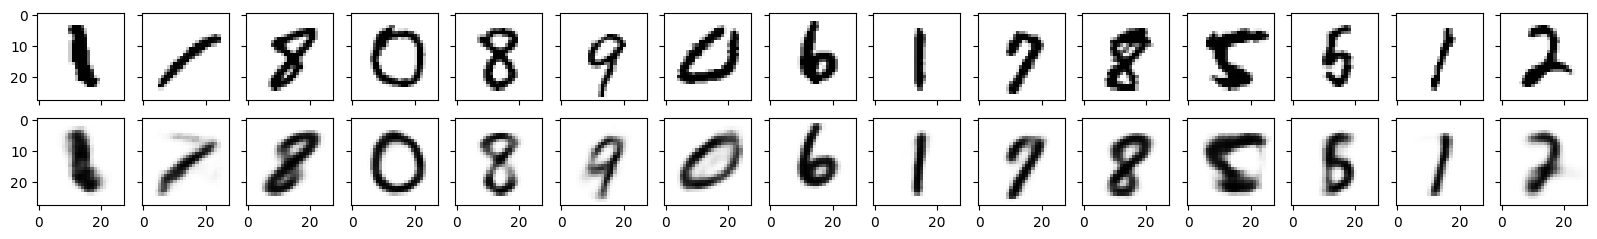

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')

### Generating new images

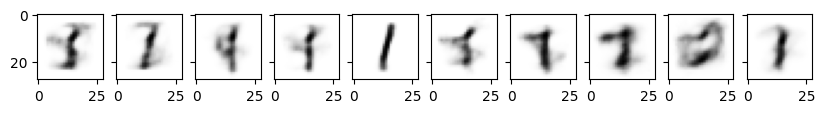

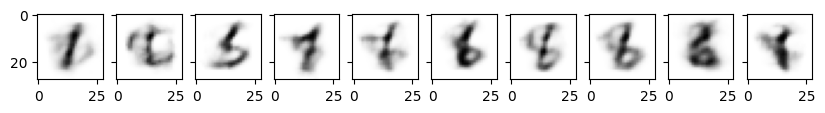

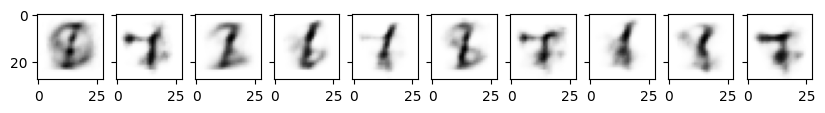

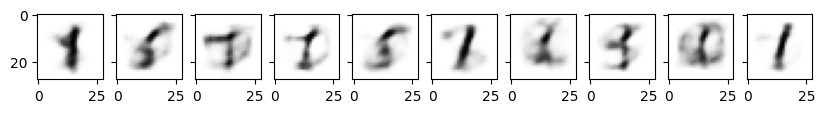

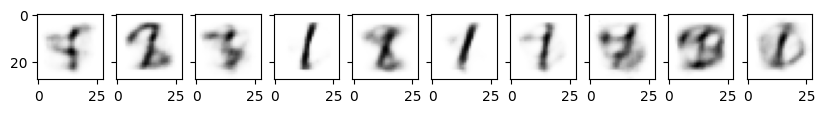

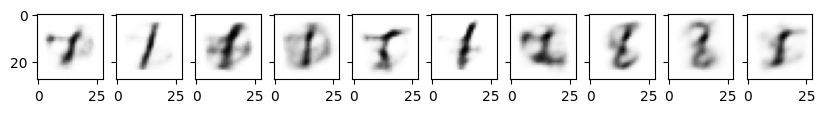

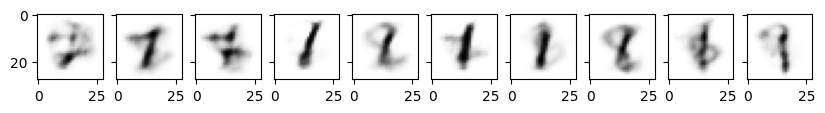

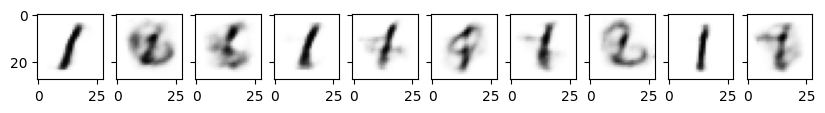

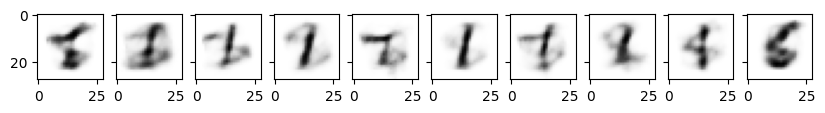

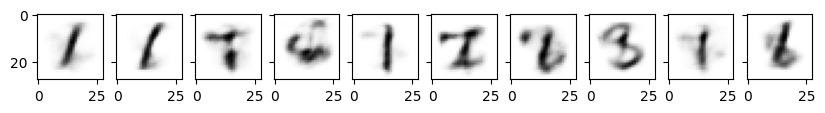

In [18]:
for i in range(10):

    ## Random Sample  
    
    n_images = 10
    rand_features = torch.randn(n_images, num_latent).to(device)
    new_images = model.decoder(rand_features)

    image_width = 28

    fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(10, 2.5), sharey=True)
    decoded_images = new_images[:n_images]

    for ax, img in zip(axes, decoded_images):
        curr_img = img.detach().to(torch.device('cpu'))
        ax.imshow(curr_img.view((image_width, image_width)), cmap='binary')
        
    plt.show()

In [19]:
%watermark -iv

numpy      : 1.26.4
matplotlib : 3.9.0
torchvision: 0.17.2
torch      : 2.2.2

